<a href="https://colab.research.google.com/github/aburak256/Currency-with-Twitter/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
 print('User uploaded file "{name}" with length {length} bytes'.format(
     name=fn, length=len(uploaded[fn])))

Saving requirements.txt to requirements.txt
User uploaded file "requirements.txt" with length 357 bytes


In [2]:
!pip install -r requirements.txt

     |████████████████████████████████| 61kB 3.3MB/s 
     |████████████████████████████████| 7.5MB 6.1MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 1.2MB 43.2MB/s 
     |████████████████████████████████| 10.5MB 33.9MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
     |████████████████████████████████| 235kB 42.6MB/s 
     |████████████████████████████████| 17.3MB 249kB/s 
     |████████████████████████████████| 28.4MB 160kB/s 
     |████████████████████████████████| 327kB 47.0MB/s 
     |████████████████████████████████| 86.4MB 52kB/s 
     |████████████████████████████████| 12.4MB 45.0MB/s 
     |████████████████████████████████| 8.7MB 47.4MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 1.1MB 39.9MB/s 
     |████████████████████████████████| 276kB 50.0MB/s 
     |████████████████████████████████| 133kB 47.8MB/s 
     |████████████████████████████████| 133kB 43.4MB/s 


In [2]:

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd #Basic library for all of our dataset operations
import numpy as np
import requests
import io
import statsmodels.tsa.api as smt
import statsmodels as sm
import tensorflow as tf
import pmdarima as pm
import warnings
import xgboost as xgb

import lightgbm as lgb
import gluonts
from math import sqrt

import shap
warnings.filterwarnings("ignore") #We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones


from pandas.plotting import autocorrelation_plot
from metrics import evaluate
from plots import bar_metrics
from statsmodels.tsa.ar_model import AR
from random import random
from datetime import datetime
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn import linear_model, svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from math import sqrt
from xgboost import plot_importance, plot_tree
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from itertools import islice
from pylab import rcParams
# progress bar
from tqdm import tqdm, tqdm_notebook
from bayes_opt import BayesianOptimization

seed = 42
tf.random.set_seed(seed)

np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

INFO:root:Using CPU


2.0.3


In [ ]:
url = 'https://raw.githubusercontent.com/aburak256/Currency-with-Twitter/main/Sum_Last.csv?token=AIJJRBHQ566QWR63THDRYHS7UF3LE'



In [3]:
exchange_rate = pd.read_csv('Last.csv',parse_dates=['Date'])
exchange_rate.set_index('Date',inplace=True)
exchange_rate.head() #

,Rate,Previous,Lag1Order2
Date,,,
2014-01-01 18:00:00,2.14686,2.14793,0.00054
2014-01-01 19:01:00,2.14680,2.14686,-0.00045
2014-01-01 20:00:00,2.14728,2.14680,-0.00037
2014-01-01 21:00:00,2.14731,2.14728,0.00034
2014-01-01 22:01:00,2.14697,2.14731,-0.00041


In [ ]:
exchange_rate.describe()

,Rate,Previous,Lag1Order2
count,37196.000000,37196.000000,3.719600e+04
mean,3.687676,3.687574,-3.629423e-08
std,1.283851,1.283822,1.526339e-02
min,2.063250,2.063250,-1.054890e+00
25%,2.707680,2.707673,-3.350000e-03
50%,3.469440,3.468835,4.000000e-05
75%,4.734715,4.734565,3.440000e-03
max,7.096780,7.096780,7.686800e-01


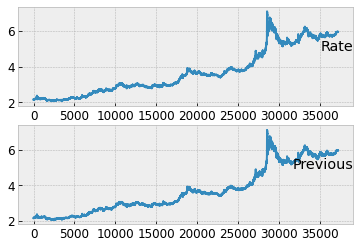

In [ ]:
values = exchange_rate.values
groups = [0, 1]
i = 1
# plot each column
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(exchange_rate.columns[group], y=0.5, loc='right')
    i += 1
    

plt.show()

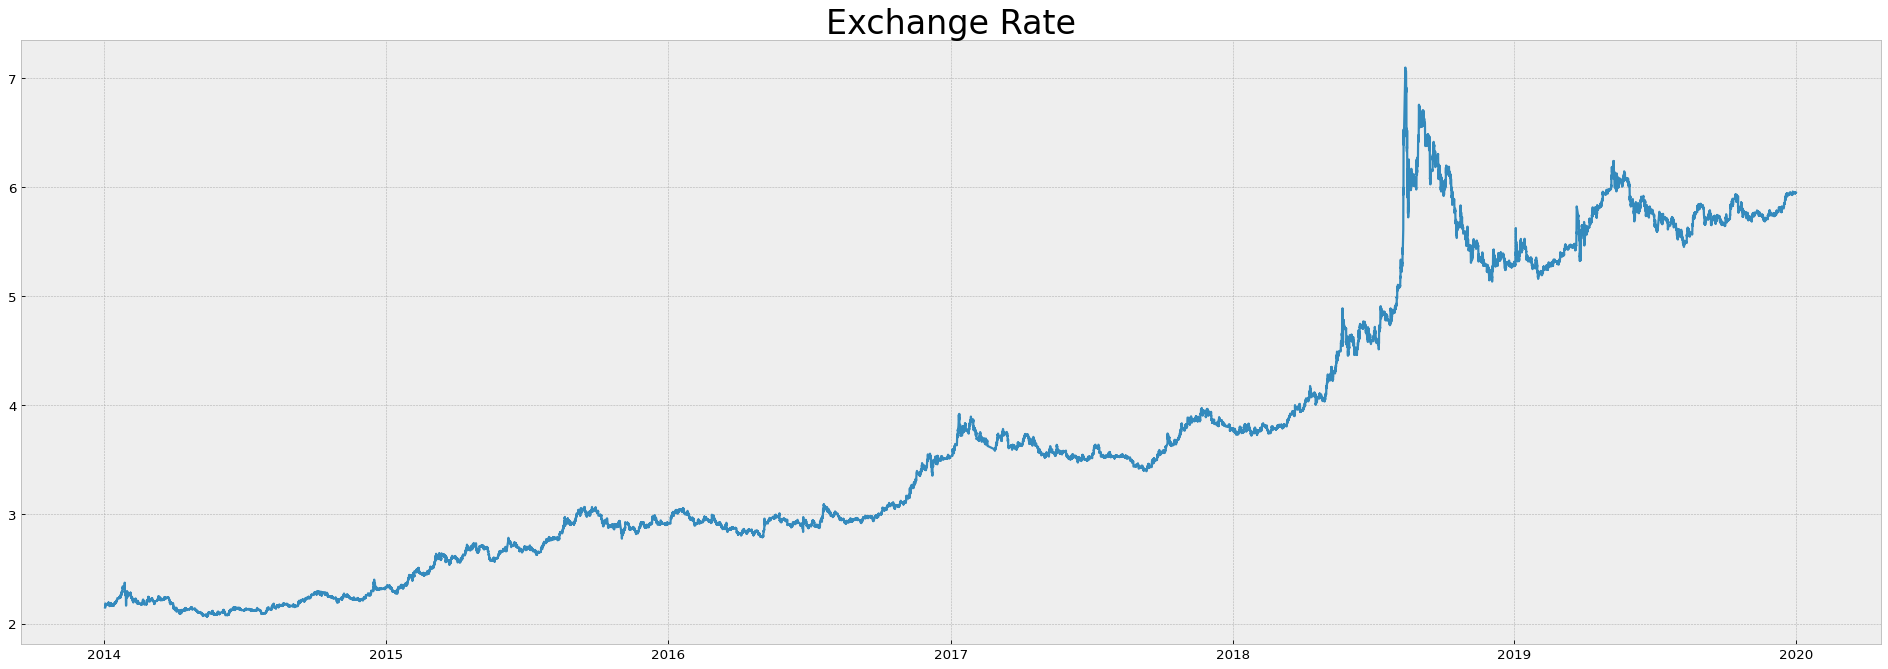

In [ ]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Exchange Rate',fontsize=30)

plt.plot(exchange_rate.Rate)
plt.savefig("pollution.png")

<Figure size 4000x1600 with 0 Axes>

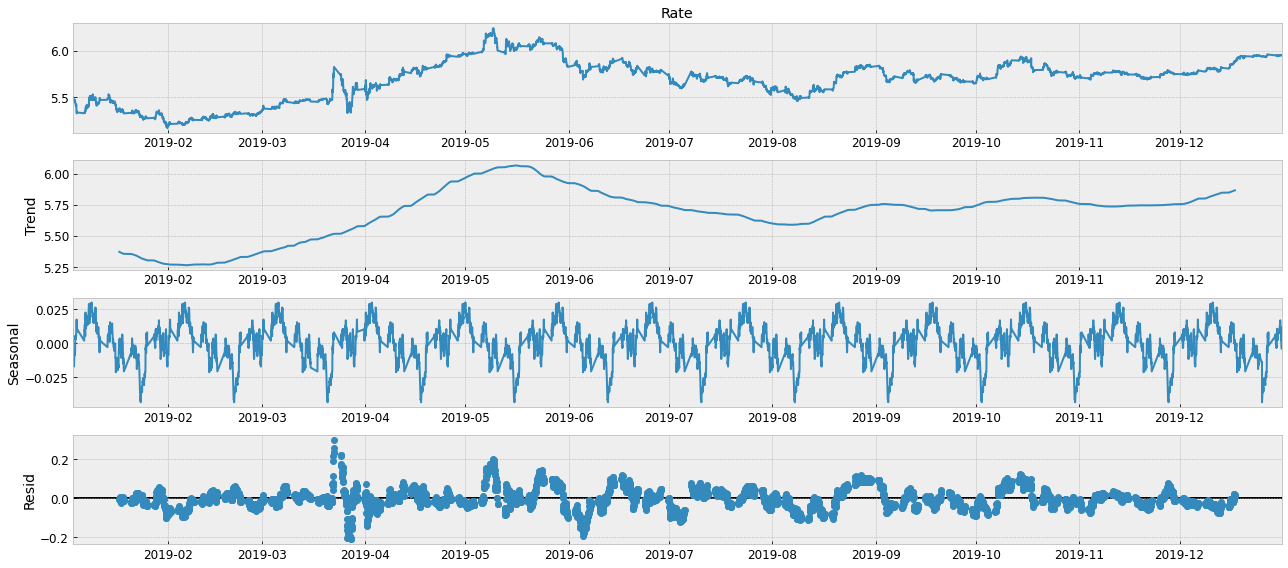

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = exchange_rate.Rate[-6200:]
result = seasonal_decompose(series, model='additive',period=480 )#additive because seasonality’s amplitude is independent of the level , period = 24* 20 (20 trading days per month)
result.plot()
pass

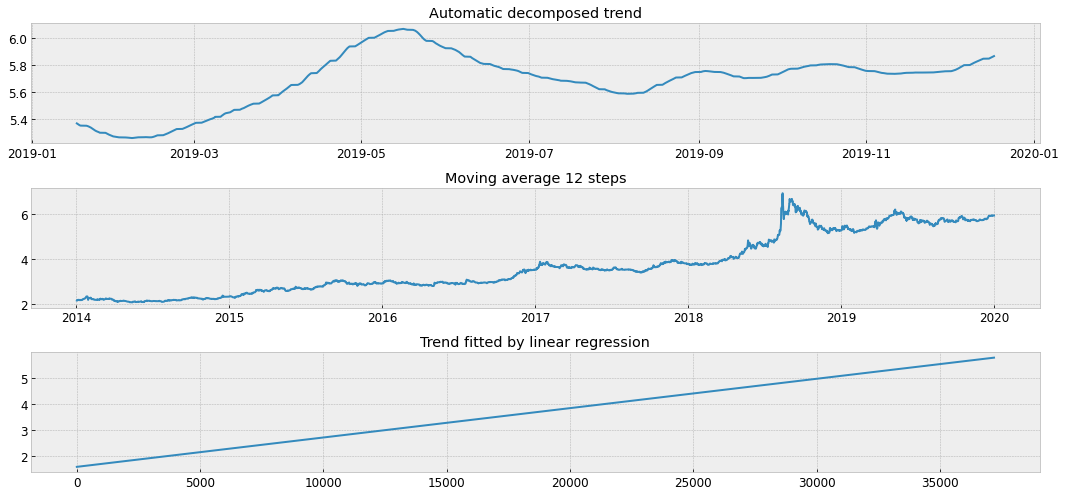

In [ ]:

fig = plt.figure(figsize=(15, 7))
layout = (3,2)
pm_ax = plt.subplot2grid(layout, (0,0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1,0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2,0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = exchange_rate.Rate.rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, len(exchange_rate.Rate))]
X = np.reshape(X, (len(X), 1))
y = exchange_rate.Rate.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

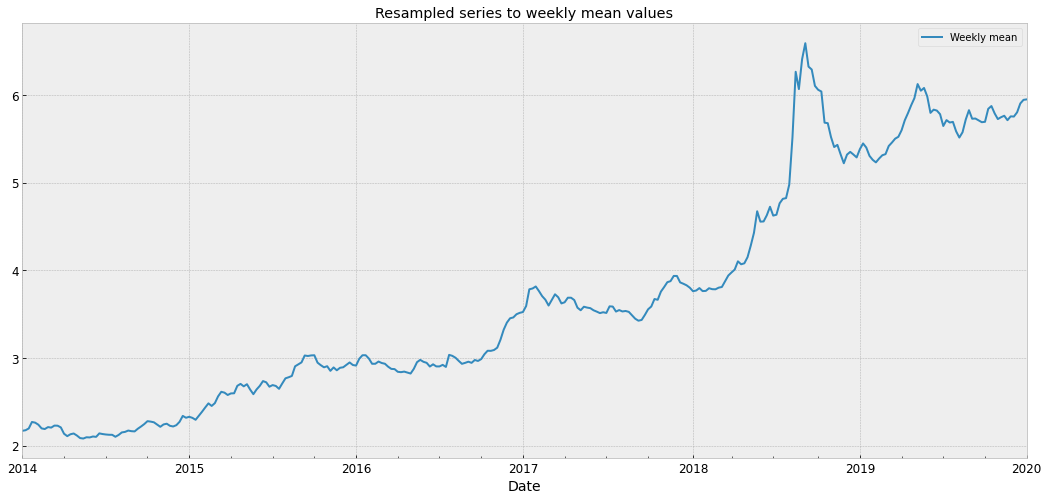

In [ ]:
#Looking for weekly seasonality
resample = exchange_rate.resample('W')
weekly_mean = resample.mean()
weekly_mean.Rate.plot(label='Weekly mean')
plt.title("Resampled series to weekly mean values")
plt.legend()

Text(0.5, 1.0, 'Mean over time')

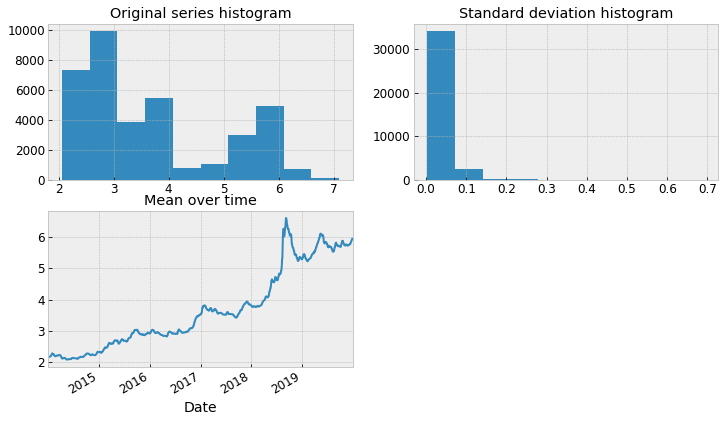

In [ ]:
series = exchange_rate.Rate.values
fig = plt.figure(figsize=(12, 7))
layout = (2,2)
hist_ax = plt.subplot2grid(layout, (0,0))
hist_std_ax = plt.subplot2grid(layout, (0,1))
mean_ax = plt.subplot2grid(layout, (1,0))

exchange_rate.Rate.hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

mm = exchange_rate.Rate.rolling(168).std()#168 hours at 1 week
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = exchange_rate.Rate.rolling(168).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")

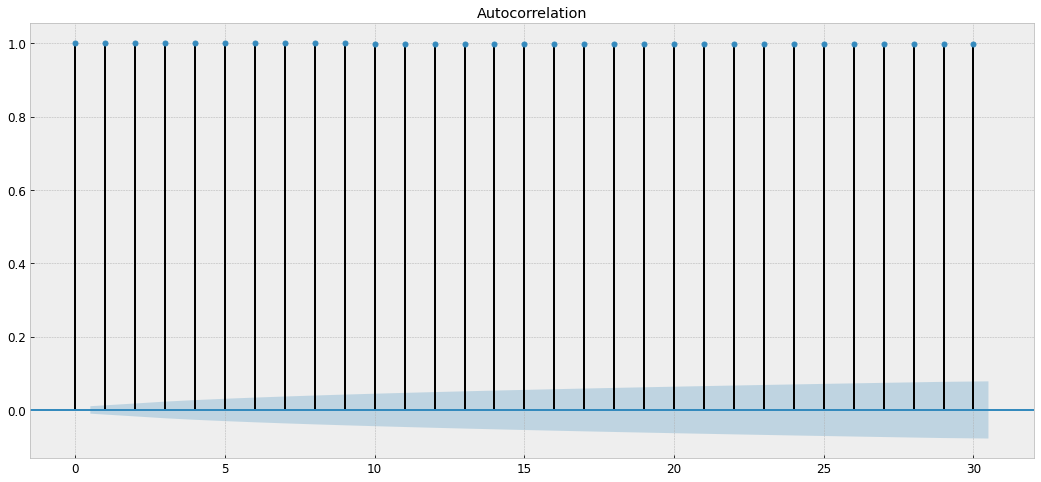

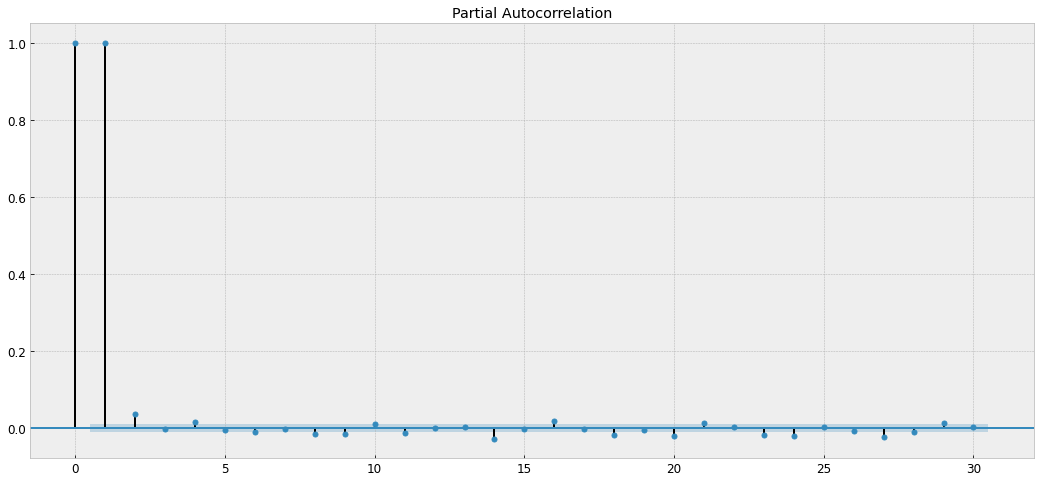

In [ ]:
plot_acf(series, lags = 30)
plot_pacf(series, lags = 30)
plt.show()

Stationary series autocorrelation values will quickly decrease over time t. This shows us that no information is carried over time and then the series should be constant over time. But if we look at our autocorrelation graph it wont decrease over time.
These graphs shows us that our data is not stationary 

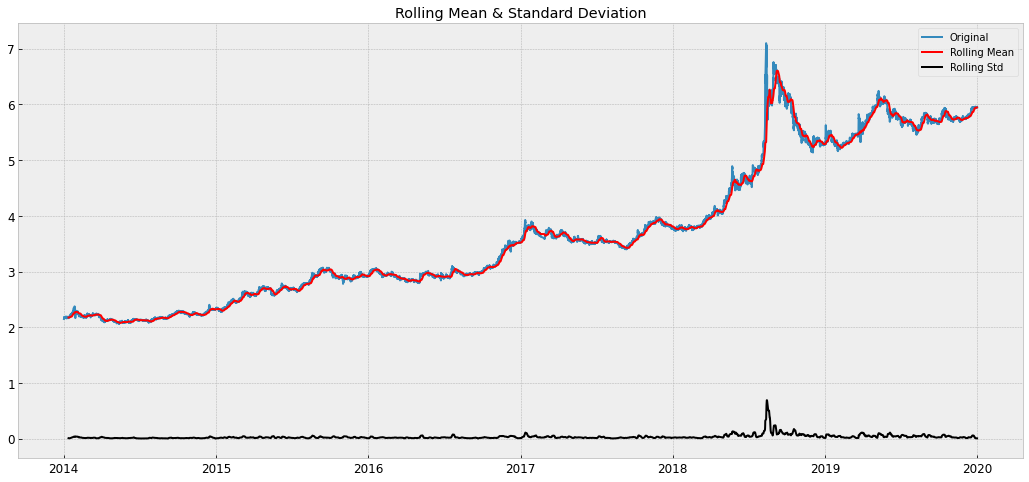

In [ ]:
rolmean = exchange_rate.Rate.rolling(window=168).mean()#168 hours at 1 week
rolstd = exchange_rate.Rate.rolling(window=168).std()

#Plot rolling statistics:
orig = plt.plot(exchange_rate.Rate,label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Also we can see that our data is not stationary using standart deviation. Mean and standard deviation should be constant over time in order to have a stationary time series.

In [ ]:
X = exchange_rate.Rate.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.238632
p-value: 0.933757
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


**The Augmented Dickey-Fuller test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. if p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary**

## Making time series stationary

Applying a difference transform to a time series could help remove the series dependence on time.

This transform is done by substracting the previous obesvation to the current one.

difference(t) = observation(t) - observation(t-1)

In [ ]:
def difference(dataset, interval=1, order=1):
    for u in range(order):
        diff = list()
        for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
        dataset=diff
    return diff

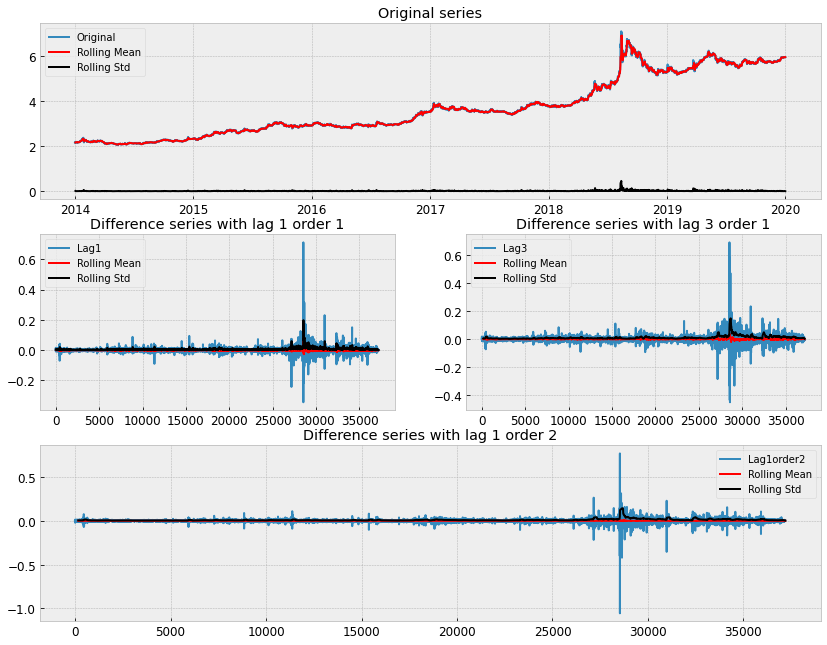

In [ ]:
lag1series = pd.Series(difference(exchange_rate.Rate, interval=1, order=1))
lag3series = pd.Series(difference(exchange_rate.Rate, interval=3, order=1))
lag1order2series = pd.Series(difference(exchange_rate.Rate, interval=1, order=2))

fig = plt.figure(figsize=(14,11))
layout = (3,2)
original = plt.subplot2grid(layout, (0,0), colspan=2)
lag1 = plt.subplot2grid(layout, (1,0))
lag3 = plt.subplot2grid(layout, (1,1))
lag1order2 = plt.subplot2grid(layout, (2,0), colspan=2)

original.set_title('Original series')
original.plot(exchange_rate.Rate, label = 'Original')
original.plot(exchange_rate.Rate.rolling(24).mean(), color='red', label='Rolling Mean')
original.plot(exchange_rate.Rate.rolling(24).std(), color='black', label = 'Rolling Std')
original.legend(loc='best')

lag1.set_title('Difference series with lag 1 order 1')
lag1.plot(lag1series, label = "Lag1")
lag1.plot(lag1series.rolling(24).mean(), color='red', label='Rolling Mean')
lag1.plot(lag1series.rolling(24).std(), color='black', label = 'Rolling Std')
lag1.legend(loc='best')

lag3.set_title('Difference series with lag 3 order 1')
lag3.plot(lag3series, label = "Lag3")
lag3.plot(lag3series.rolling(168).mean(), color='red', label='Rolling Mean')
lag3.plot(lag3series.rolling(168).std(), color='black', label = 'Rolling Std')
lag3.legend(loc='best')

lag1order2.set_title('Difference series with lag 1 order 2')
lag1order2.plot(lag1order2series, label = "Lag1order2")
lag1order2.plot(lag1order2series.rolling(168).mean(), color='red', label='Rolling Mean')
lag1order2.plot(lag1order2series.rolling(168).std(), color='black', label = 'Rolling Std')
lag1order2.legend(loc='best')

In [4]:
resultsDict={}
predictionsDict={}

split_date ='2019-12-25 00:00'
df_training = exchange_rate.loc[exchange_rate.index <= split_date]
df_test = exchange_rate.loc[exchange_rate.index > split_date]
print(f"{len(df_training)} hours of training data \n {len(df_test)} hours of testing data ")


df_training.to_csv('training.csv')
df_test.to_csv('test.csv')


37086 hours of training data 
 110 hours of testing data 


In [5]:
mean = df_test.Rate.mean()
mean = np.array([mean for u in range(len(df_test))])
resultsDict['Naive mean'] = evaluate(df_test.Rate, mean)
predictionsDict['Naive mean'] = mean
resultsDict['Yesterdays value'] = evaluate(df_test.Rate, df_test.Previous)
predictionsDict['Yesterdays value'] = df_test.Previous.values

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


**Simple Exponential Smoothing (SES)**

The Simple Exponential Smoothing (SES) method models the next time step as an exponentially weighted linear function of observations at prior time steps. This method expects our time series to be non stationary in order to perform adecuately (no trend or seasonality)

In [88]:
index = len(df_training)
yhat = list()
# Walk throught the test data, training and predicting 1 day ahead for all the test data
for t in tqdm(range(len(df_test.Rate))):
    temp_train = exchange_rate[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train.Rate)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['SES'] = evaluate(df_test.Rate, yhat.values)
predictionsDict['SES'] = yhat.values

100%|██████████| 110/110 [00:17<00:00,  6.20it/s]


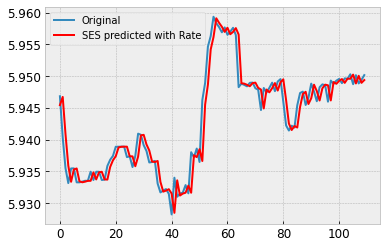

In [89]:
plt.plot(df_test.Rate.values, label='Original')
plt.plot(yhat.values,color='red',label='SES predicted with Rate')
plt.legend()

In [90]:
error = mean_squared_error(df_test.Rate, yhat.values)
print('Test MSE: %.8f' % error)

Test MSE: 0.00000539


In [91]:
index = len(df_training)
yhat = list()
# Walk throught the test data, training and predicting 1 day ahead for all the test data
for t in tqdm(range(len(df_test.Rate))):
    temp_train = exchange_rate[:len(df_training)+t]
    model = ExponentialSmoothing(temp_train.Rate)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['HWES'] = evaluate(df_test.Rate, yhat.values)
predictionsDict['HWES'] = yhat.values

100%|██████████| 110/110 [00:17<00:00,  6.12it/s]


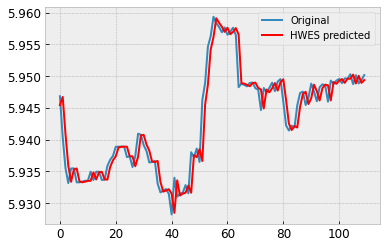

In [92]:
plt.plot(df_test.Rate.values, label='Original')
plt.plot(yhat.values,color='red',label='HWES predicted')
plt.legend()

In [ ]:
error = mean_squared_error(df_test.Rate, yhat.values)
print('Test MSE: %.8f' % error)

Test MSE: 0.00000539


In [93]:
index = len(df_training)
yhat = list()
# Walk throught the test data, training and predicting 1 day ahead for all the test data
for t in tqdm(range(len(df_test.Rate))):
    temp_train = exchange_rate[:len(df_training)+t]
    model = AR(temp_train.Rate)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['AR'] = evaluate(df_test.Rate, yhat.values)
predictionsDict['AR'] = yhat.values

100%|██████████| 110/110 [00:50<00:00,  2.16it/s]


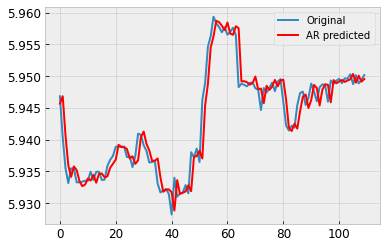

In [94]:
plt.plot(df_test.Rate.values, label='Original')
plt.plot(yhat.values,color='red',label='AR predicted')
plt.legend()

In [95]:
error = mean_squared_error(df_test.Rate, yhat.values)
print('Test MSE: %.8f' % error)

Test MSE: 0.00000563


**Moving Average**

In [96]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

index = len(df_training)
yhat = list()
# Walk throught the test data, training and predicting 1 day ahead for all the test data
for t in tqdm(range(len(df_test.Rate))):
    temp_train = exchange_rate[:len(df_training)+t]
    model = ARIMA(temp_train.Rate,order=(1,0, 0))
    model_fit = model.fit(display = False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test.Rate, yhat.values)
predictionsDict['ARIMA'] = yhat.values

100%|██████████| 110/110 [02:45<00:00,  1.50s/it]


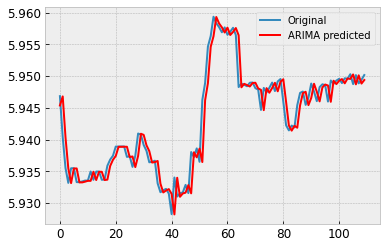

In [97]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat.values,color='red',label='ARIMA predicted')
plt.legend()

In [98]:
error = mean_squared_error(df_test.Rate, yhat.values)
print('Test MSE: %.8f' % error)

Test MSE: 0.00000535


## Auto ARIMA

In [99]:
X = exchange_rate.Rate[-1500:].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)


Test MSE: 0.00002085


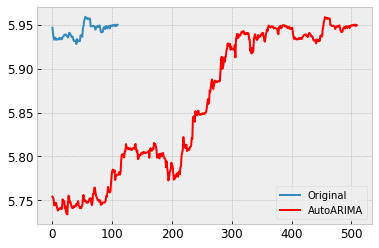

In [100]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.8f' % error)
plt.plot(df_test.Rate.values , label='Original')
plt.plot(predictions,color='red',label='AutoARIMA')
plt.legend()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.Rate))):
    temp_train = exchange_rate[:len(df_training)+t]
    model = SARIMAX(temp_train.Rate, order=(1, 0, 0), seasonal_order=(0, 0, 0, 3))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['SARIMAX'] = evaluate(df_test.Rate, yhat.values)
predictionsDict['SARIMAX'] = yhat.values

100%|██████████| 110/110 [12:38<00:00,  6.90s/it]


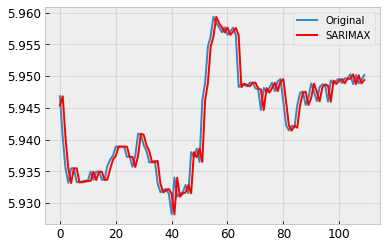

In [ ]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat.values,color='red',label='SARIMAX')
plt.legend()

In [ ]:
error = mean_squared_error(df_test.Rate, yhat.values)
print('Test MSE for SARIMAX: %.8f' % error)

Test MSE for SARIMAX: 0.00000536


In [7]:
def create_time_features(df,target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'],axis=1)
    if target:
        y = df[target]
        X = X.drop([target],axis=1)
        return X, y
    
    return X

In [8]:
X_train_df, y_train = create_time_features(df_training, target='Rate')
X_test_df, y_test = create_time_features(df_test, target='Rate')
scaler = StandardScaler() 
scaler.fit(X_train_df) 
X_train = scaler.transform(X_train_df)  
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train,columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test,columns=X_test_df.columns)

In [101]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['BayesianRidge'] = evaluate(df_test.Rate, yhat)
predictionsDict['BayesianRidge'] = yhat

Test MSE: 0.00000525


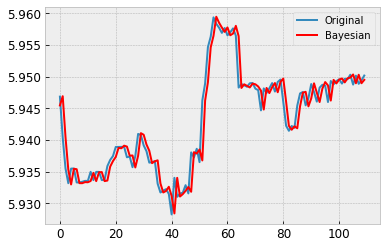

In [102]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat,color='red',label='Bayesian')
plt.legend()
error = mean_squared_error(df_test.Rate, yhat)
print('Test MSE: %.8f' % error)

In [103]:
reg = linear_model.Lasso(alpha=0.0001) #If alpha value increase, models complexity reduces. So set the alpha value smaller
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Lasso'] = evaluate(df_test.Rate, yhat)
predictionsDict['Lasso'] = yhat

Test MSE: 0.00000533


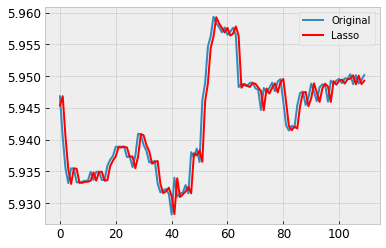

In [104]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat,color='red',label='Lasso')
plt.legend()
error = mean_squared_error(df_test.Rate, yhat)
print('Test MSE: %.8f' % error)              

Tested alpha values to get a better result.

Minimum alpha value for result is 0.0001. If we choose smaller alpha it didn't changes the MSE.

alpha = 0.01 MSE = 0.0003


In [105]:
reg = RandomForestRegressor(max_depth=16, random_state=0)  #set higher max_depth because it represents depth of each tree in the forest 
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Randomforest'] = evaluate(df_test.Rate, yhat)
predictionsDict['Randomforest'] = yhat

Test MSE: 0.00002247


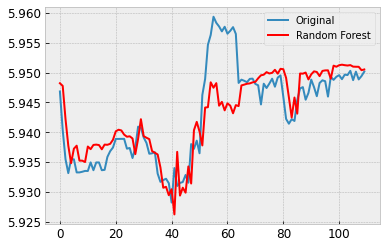

In [106]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat,color='red',label='Random Forest')
plt.legend()
error = mean_squared_error(df_test.Rate, yhat)
print('Test MSE: %.8f' % error)

depth = 8 MSE = 0.00003

depth = 16 MSE = 0.00002

depth = 32 MSE = 0.00002

So the optimal depth for this model should be 16

In [81]:
reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=300, max_depth=5)
reg.fit(X_train, y_train,
       verbose=False) # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test.Rate, yhat)
predictionsDict['XGBoost'] = yhat

Test MSE: 0.00002243


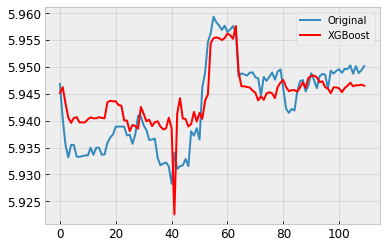

In [82]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat,color='red',label='XGBoost')
plt.legend()
error = mean_squared_error(df_test.Rate, yhat)
print('Test MSE: %.8f' % error)

300 estimator and 5 depth = 0.00002

1000 estimators and default depth = 0.00010

In [79]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train,y_train)
yhat = lightGBM.predict(X_test)
resultsDict['Lightgbm'] = evaluate(df_test.Rate, yhat)
predictionsDict['Lightgbm'] = yhat

Test MSE: 0.00006266


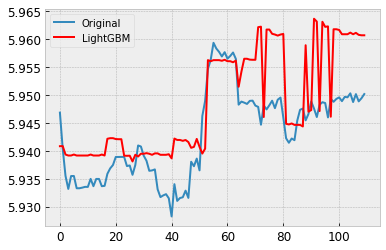

In [80]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat,color='red',label='LightGBM')
plt.legend()
error = mean_squared_error(df_test.Rate, yhat)
print('Test MSE: %.8f' % error)

The value of epsilon defines a margin of tolerance where no penalty is given to errors.

Also larger epsilon is, the larger errors

In [9]:
reg = svm.SVR(kernel='rbf', C=100, epsilon=0.1 , gamma=0.1) 
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM RBF'] = evaluate(df_test.Rate, yhat)
predictionsDict['SVM RBF'] = yhat

Test MSE: 0.07225315


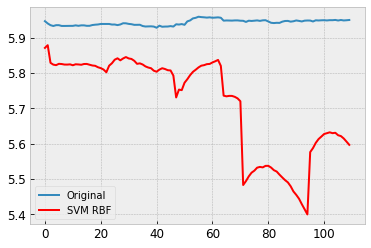

In [10]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat,color='red',label='SVM RBF')
plt.legend()
error = mean_squared_error(df_test.Rate, yhat)
print('Test MSE: %.8f' % error)

epsilon 0.1 C = 100 gamma = 0.1  - RESULT = 0.07

When I changed the epsilon value to 0.01 cell didn't finished

In [25]:
reg = KNeighborsRegressor(n_neighbors=100)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Kneighbors'] = evaluate(df_test.Rate, yhat)
predictionsDict['Kneighbors'] = yhat

Test MSE: 0.09003102


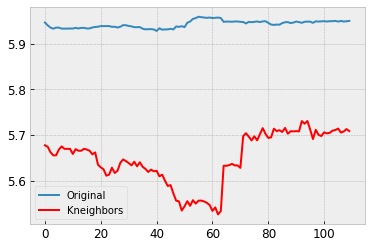

In [26]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat,color='red',label='Kneighbors')
plt.legend()
error = mean_squared_error(df_test.Rate, yhat)
print('Test MSE: %.8f' % error)

number of neigbors = 2 RESULT = 0.36

number of neigbors = 10 RESULT = 0.30

number of neigbors = 100 RESULT = 0.09

number of neigbors = 1000 RESULT = 0.25

In [54]:
BATCH_SIZE = 128
BUFFER_SIZE = 50
WINDOW_LENGTH = 24
def window_data(X,Y,window=24):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x=[]
    y=[]
    for i in range(window-1,len(X)):
        x.append(X[i-window+1:i+1]) 
        y.append(Y[i])
    return np.array(x), np.array(y)
        
#Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w,y_w = window_data(X_w,y_w,window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

#Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [55]:
dropout=0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=X_train_w.shape[-2:],dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='rmsprop', loss='mae')

In [56]:
EVALUATION_INTERVAL = len(X_train) / BATCH_SIZE
EPOCHS = 50

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_data, validation_steps=50)

Train for 289.734375 steps, validate for 50 steps
Epoch 1/50
290/289 [==============================] - 27s 93ms/step - loss: 0.5128 - val_loss: 0.1546
Epoch 2/50
290/289 [==============================] - 24s 84ms/step - loss: 0.2951 - val_loss: 0.1186
Epoch 3/50
290/289 [==============================] - 24s 84ms/step - loss: 0.2408 - val_loss: 0.2484
Epoch 4/50
290/289 [==============================] - 24s 84ms/step - loss: 0.2058 - val_loss: 0.1702
Epoch 5/50
290/289 [==============================] - 24s 84ms/step - loss: 0.1960 - val_loss: 0.1376
Epoch 6/50
290/289 [==============================] - 24s 84ms/step - loss: 0.1712 - val_loss: 0.2144
Epoch 7/50
290/289 [==============================] - 25s 85ms/step - loss: 0.1521 - val_loss: 0.3597
Epoch 8/50
290/289 [==============================] - 24s 82ms/step - loss: 0.1426 - val_loss: 0.2951
Epoch 9/50
290/289 [==============================] - 24s 83ms/step - loss: 0.1285 - val_loss: 0.1495
Epoch 10/50
290/289 [===========

In [61]:
yhat = simple_lstm_model.predict(X_test_w).reshape(1,-1)[0]
resultsDict['Tensorflow simple LSTM'] = evaluate(y_test,yhat)
predictionsDict['Tensorflow simple LSTM'] = yhat

Test MSE: 0.00307636


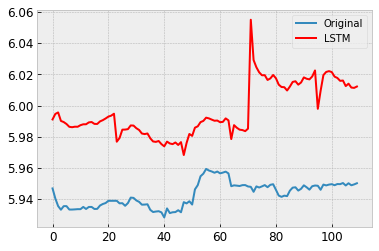

In [62]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat,color='red',label='LSTM')
plt.legend()
error = mean_squared_error(df_test.Rate, yhat)
print('Test MSE: %.8f' % error)

BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24
Window = 168
Result = 2.5

BATCH_SIZE = 512
BUFFER_SIZE = 1000
WINDOW_LENGTH = 120
Window = 120
Result = 0.8

BATCH_SIZE = 128
BUFFER_SIZE = 1000
WINDOW_LENGTH = 120
Window = 120
Result = 4.5

BATCH_SIZE = 128
BUFFER_SIZE = 100
WINDOW_LENGTH = 24
window = 120
Result = 0.13

BATCH_SIZE = 128
BUFFER_SIZE = 50
WINDOW_LENGTH = 24
window = 24
Epoch = 50
Result = 0.03

In [57]:
features = ['Previous', 'Lag1Order2', 'hour', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'sin_day', 'cos_day', 'dayofmonth', 'weekofyear']

scaler = StandardScaler() 
scaler.fit(X_train) #No cheating, never scale on the training+test!
df_training[features] = scaler.transform(df_training[features])  
df_test[features] = scaler.transform(df_test[features])


training_data = ListDataset(
    [{"start": df_training.index[0], "target": df_training.Rate,
      'feat_dynamic_real': [df_training[feature] for feature in features]
      }],
    freq="d"
)
test_data = ListDataset(
    [{"start": df_test.index[0], "target": df_test.Rate,
      'feat_dynamic_real': [df_test[feature] for feature in features]
      }],
    freq="d"
)

In [74]:
estimator = DeepAREstimator(freq="d",
                            prediction_length=1
                            , context_length=20,
                            trainer=Trainer(epochs=20))

predictor = estimator.train(training_data=training_data)





forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_samples=len(df_test))

forecasts = list(forecast_it)
tss = list(ts_it)

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:14<00:00,  3.37it/s, avg_epoch_loss=0.907]
INFO:root:Epoch[0] Elapsed time 14.865 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.907175
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:14<00:00,  3.47it/s, avg_epoch_loss=-1.24]
INFO:root:Epoch[1] Elapsed time 14.398 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-1.237337
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:14<00:00,  3.37it/s, avg_epoch_loss=-1.31]
INFO:root:Epoch[2] Elapsed time 14.844 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-1.313350
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:14<00:00,  3.42it/s, avg_epoch_loss=-1.41]
INFO:root:Epoch[3] Elapsed time 14.609 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-1.408473
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:14<00

In [75]:
yhat = forecasts[0].samples.reshape(1,-1)[0]
resultsDict['DeepAR'] = evaluate(y_test,yhat)
predictionsDict['DeepAR'] = yhat

Test MSE: 0.00323613


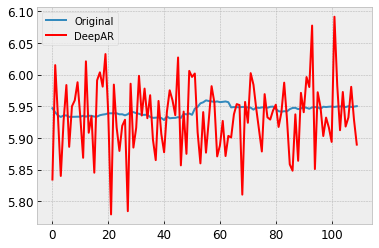

In [76]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat,color='red',label='DeepAR')
plt.legend()
error = mean_squared_error(df_test.Rate, yhat)
print('Test MSE: %.8f' % error)

prediction_length=1
context_length=30,
trainer=Trainer(epochs=5)
Result = 0.21

context_length=20,
trainer=Trainer(epochs=50)
result = 0.006

context_length=20,
trainer=Trainer(epochs=10)
Result = 0.005

context_length=40,
trainer=Trainer(epochs=10)
Result = 0.030

context_length=20,
trainer=Trainer(epochs=20)
Result = 0.003

# **ENSEMBLING**

In [83]:
models = ['Tensorflow simple LSTM',
 'Lightgbm',
 'XGBoost']
resis = pd.DataFrame(data={k: df_test.Rate.values - v for k, v in predictionsDict.items()})[models]
corr = resis.corr()
print("Residuals correlation")
corr.style.background_gradient(cmap='coolwarm')

Residuals correlation


,Tensorflow simple LSTM,Lightgbm,XGBoost
Tensorflow simple LSTM,1,0.478962,-0.117403
Lightgbm,0.478962,1,0.0325557
XGBoost,-0.117403,0.0325557,1


In [107]:
predictionsDict['EnsembleXG+LIGHT'] = (predictionsDict['XGBoost'] + predictionsDict['Lightgbm'])/2
resultsDict['EnsembleXG+LIGHT'] = evaluate(df_test.Rate.values,predictionsDict['EnsembleXG+LIGHT'])

predictionsDict['EnsembleXG+LIGHT+TF'] = (predictionsDict['XGBoost'] + predictionsDict['Lightgbm']+ predictionsDict['Tensorflow simple LSTM'])/3
resultsDict['EnsembleXG+LIGHT+TF'] = evaluate(df_test.Rate.values,predictionsDict['EnsembleXG+LIGHT+TF'])

predictionsDict['EnsembleLIGHT+TF'] = (predictionsDict['Lightgbm']+ predictionsDict['Tensorflow simple LSTM'])/2
resultsDict['EnsembleLIGHT+TF'] = evaluate(df_test.Rate.values,predictionsDict['EnsembleLIGHT+TF'])

predictionsDict['EnsembleXG+TF'] = (predictionsDict['XGBoost']+ predictionsDict['Tensorflow simple LSTM'])/2
resultsDict['EnsembleXG+TF'] = evaluate(df_test.Rate.values,predictionsDict['EnsembleXG+TF'])

In [108]:
import pickle

with open('scores.pickle', 'wb') as handle:
    pickle.dump(resultsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('predictions.pickle', 'wb') as handle:
    pickle.dump(predictionsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)